In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

In [3]:
url_front = 'http://data.insideairbnb.com/singapore/sg/singapore/'
url_end_calendars = '/data/calendar.csv.gz'

# Combine Data

In [4]:
dates = ['2019-03-18', '2019-04-20', '2019-05-23', '2019-06-25', '2019-07-21', '2019-08-28', '2019-09-25', '2019-10-25', '2019-11-26', '2019-12-28',
         '2020-01-26', '2020-02-27', '2020-03-21', '2020-04-26', '2020-05-27', '2020-06-22', '2020-10-26', '2020-11-27', '2020-12-29','2021-01-27']

In [5]:
calendars = []

In [6]:
for date in dates:
    # print(date)
    calendar = pd.read_csv(url_front + date + url_end_calendars)
    calendars.append(calendar)

In [7]:
calendars_full = calendars[0]
for i in range(1, len(dates)-1):
    calendars_full = pd.concat([calendars_full, calendars[i]])

In [8]:
calendars_full.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,49091,2019-03-18,t,$81.00,$81.00,180.0,360.0
1,49091,2019-03-19,t,$81.00,$81.00,180.0,360.0
2,49091,2019-03-20,t,$81.00,$81.00,180.0,360.0
3,49091,2019-03-21,t,$81.00,$81.00,180.0,360.0
4,49091,2019-03-22,t,$81.00,$81.00,180.0,360.0


In [9]:
calendars_full.shape

(50721752, 7)

In [10]:
calendars_full['price'].isnull().value_counts()

False    50718004
True         3748
Name: price, dtype: int64

In [11]:
calendars_full['adjusted_price'].isnull().value_counts()

False    50718004
True         3748
Name: adjusted_price, dtype: int64

In [12]:
# drop duplicate rows & do not have price data
calendars_full = calendars_full.drop_duplicates()
calendars_full = calendars_full.dropna(subset = ['price'])

In [13]:
calendars_full.shape

(21193818, 7)

In [15]:
calendars_full.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,49091,2019-03-18,t,$81.00,$81.00,180.0,360.0
1,49091,2019-03-19,t,$81.00,$81.00,180.0,360.0
2,49091,2019-03-20,t,$81.00,$81.00,180.0,360.0
3,49091,2019-03-21,t,$81.00,$81.00,180.0,360.0
4,49091,2019-03-22,t,$81.00,$81.00,180.0,360.0


In [16]:
# calendars_full.to_csv('./calendars_full.csv', index = False)

### EDA 3.2: Prices of Accommodations Rise During the December-February Period

In [17]:
calendars_full['month'] = calendars_full['date'].apply(lambda x: x[0:7])

In [18]:
# delete all the month in the future
lst_date = dates[-1]
calendars_full = calendars_full.query('month <= @lst_date')
calendars_full['month'].value_counts()

2020-03    1099351
2020-05    1065684
2020-04    1042684
2020-01    1024282
2020-06    1008412
2019-12     995527
2020-07     960830
2020-02     960616
2020-08     874499
2019-11     867051
2019-10     825844
2020-09     773803
2020-12     759264
2020-11     755403
2020-10     750601
2021-01     719878
2019-09     715600
2019-08     628955
2019-07     579298
2019-06     454794
2019-05     379309
2019-04     281928
2019-03     111622
Name: month, dtype: int64

In [19]:
calendars_full['price'] = calendars_full['price'].apply(lambda x: float(x[1:-3].replace(',', '')))
calendars_full.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,month
0,49091,2019-03-18,t,81.0,$81.00,180.0,360.0,2019-03
1,49091,2019-03-19,t,81.0,$81.00,180.0,360.0,2019-03


In [23]:
# get mean price of each month
calendars_mean_date = calendars_full[['date', 'price']].groupby(['date']).mean()
calendars_mean_date_df = pd.DataFrame(calendars_mean_date)
calendars_mean_date_df.rename(columns = {'price': 'mean_price'}, inplace = True)
calendars_mean_date_df.reset_index(inplace = True)

## plot the calendar heatmap of prices

In [71]:
df = calendars_mean_date_df

In [75]:
df = df.groupby(['date']).mean()
df.index = pd.to_datetime(df.index)

In [76]:
from matplotlib import colors

# Turn data frame to a dictionary for easy access
cal = {'2019': df[df.index.year == 2019], '2020': df[df.index.year == 2020]}

# Define Ticks
DAYS = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


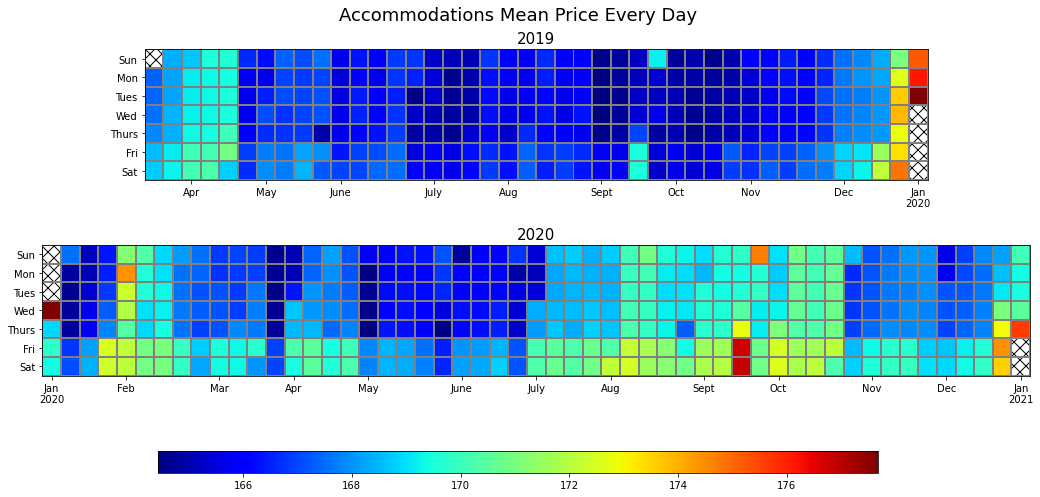

In [96]:
fig, ax = plt.subplots(2, 1, figsize = (20,6))
for i, val in enumerate(['2019', '2020']):
    start = cal.get(val).index.min()
    end = cal.get(val).index.max()
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun =  end + np.timedelta64(7 - end.dayofweek -1, 'D')
    
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.full([7, num_weeks], np.nan)    
    ticks = {}
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date <= end:
                heatmap[day, week] = cal.get(val).loc[date, 'mean_price']
    mesh = ax[i].pcolormesh(x, y, heatmap, cmap = 'jet', edgecolors = 'grey')

    ax[i].invert_yaxis()

    # Set the ticks.
    ax[i].set_xticks(list(ticks.keys()))
    ax[i].set_xticklabels(list(ticks.values()))
    ax[i].set_yticks(np.arange(7))
    ax[i].set_yticklabels(DAYS)
    ax[i].set_ylim(6.5,-0.5)
    ax[i].set_aspect('equal')
    ax[i].set_title(val, fontsize = 15)

    # Hatch for out of bound values in a year
    ax[i].patch.set(hatch='xx', edgecolor='black')

# Add color bar at the bottom
cbar_ax = fig.add_axes([0.25, -0.10, 0.5, 0.05])
fig.colorbar(mesh, orientation="horizontal", pad=0.2, cax = cbar_ax)
colorbar = ax[1].collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
fig.suptitle('Accommodations Mean Price Every Day', fontsize = 18)
fig.subplots_adjust(hspace = 0.5)

## plot the monthly price change

In [17]:
# get mean price of each month
calendars_mean = calendars_full[['listing_id', 'month', 'price']].groupby(['listing_id','month']).mean()
calendars_mean_df = pd.DataFrame(calendars_mean)
calendars_mean_df.rename(columns = {'price': 'mean_price'}, inplace = True)
calendars_mean_df.reset_index(inplace = True)

In [18]:
calendars_mean_df.head()

,listing_id,month,mean_price
0,49091,2019-03,81.00
1,49091,2019-04,81.00
2,49091,2019-05,81.45
3,49091,2019-06,82.00
4,49091,2019-07,82.00


In [19]:
# create new column previous_listing_id
calendars_mean_df['previous_listing_id'] = calendars_mean_df['listing_id'].shift(1)
calendars_mean_df['previous_listing_id'][0] = 0
calendars_mean_df['previous_listing_id'] = calendars_mean_df['previous_listing_id'].apply(lambda x: int(x))
# create new column previous_mean_price
calendars_mean_df['previous_mean_price'] = calendars_mean_df['mean_price'].shift(1)
calendars_mean_df['previous_mean_price'][0] = calendars_mean_df['mean_price'][0]
# create new column diff_mean_price: difference between this month's mean_price to last month's
calendars_mean_df['diff_mean_price'] = 0
calendars_mean_df['diff_mean_price'] = calendars_mean_df.apply(
    lambda row: row.mean_price - row.previous_mean_price if row.listing_id == row.previous_listing_id else 0, axis=1)
# create new column change_price_perc 
calendars_mean_df['change_price_perc'] = calendars_mean_df['diff_mean_price']/calendars_mean_df['previous_mean_price']

<ipython-input-19-1a1a625bd402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendars_mean_df['previous_listing_id'][0] = 0
<ipython-input-19-1a1a625bd402>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendars_mean_df['previous_mean_price'][0] = calendars_mean_df['mean_price'][0]


In [20]:
calendars_mean_df.head()

,listing_id,month,mean_price,previous_listing_id,previous_mean_price,diff_mean_price,change_price_perc
0,49091,2019-03,81.00,0,81.00,0.00,0.000000
1,49091,2019-04,81.00,49091,81.00,0.00,0.000000
2,49091,2019-05,81.45,49091,81.00,0.45,0.005556
3,49091,2019-06,82.00,49091,81.45,0.55,0.006753
4,49091,2019-07,82.00,49091,82.00,0.00,0.000000


In [21]:
# get mean price of each month
# get mean change of mean_price of each month (group by month)
calendars_mean_total = calendars_mean_df[['month', 'mean_price']].groupby(['month']).mean()
calendars_mean_total_df = pd.DataFrame(calendars_mean_total)
calendars_mean_total_df.rename(columns = {'mean_price': 'mean_price_month'}, inplace = True)
calendars_mean_total_df.reset_index(inplace = True)

In [22]:
calendars_mean_total.head()

,month,mean_price_month
0,2019-03,164.418242
1,2019-04,164.583522
2,2019-05,163.578741
3,2019-06,163.024692
4,2019-07,165.128516


Text(0, 0.5, 'Average Price')

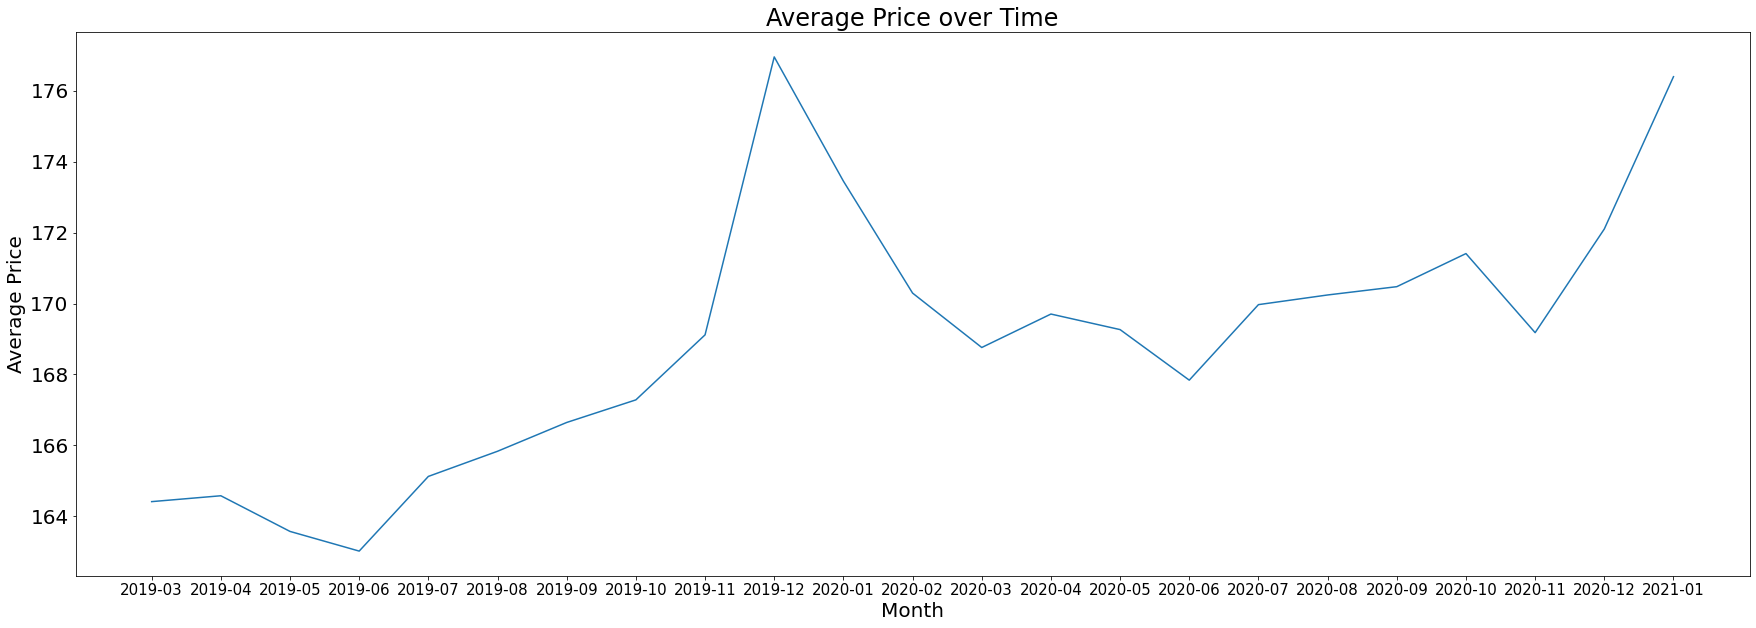

In [23]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(30, 10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.plot('month', 'mean_price_month', data = calendars_mean_total_df)
plt.title('Average Price over Time')
plt.xlabel('Month')
plt.ylabel('Average Price')

In [24]:
# get mean change of mean_price of each month (group by month)
calendars_change = calendars_mean_df[['month', 'change_price_perc']].groupby(['month']).mean()
calendars_change_df = pd.DataFrame(calendars_change)
calendars_change_df.rename(columns = {'change_price_perc': 'mean_change_price_perc'}, inplace = True)
calendars_change_df.reset_index(inplace = True)

In [25]:
calendars_change_df.head()

,month,mean_change_price_perc
0,2019-03,0.000000
1,2019-04,0.012830
2,2019-05,0.001445
3,2019-06,0.012955
4,2019-07,0.012100


Text(0, 0.5, 'Price Fluctuation')

<Figure size 2160x720 with 0 Axes>

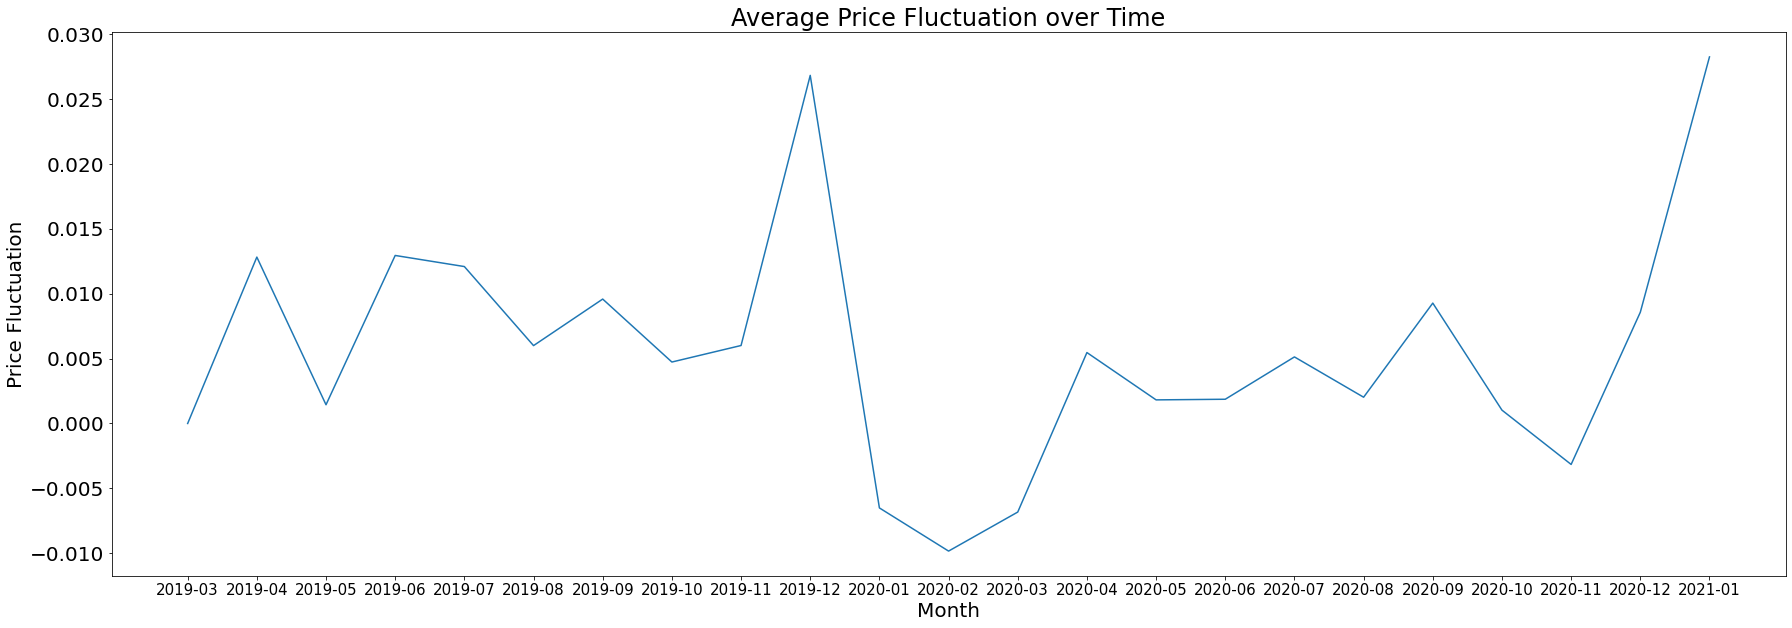

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.figure(figsize=(30, 10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.plot('month', 'mean_change_price_perc', data = calendars_change_df)
plt.title('Average Price Fluctuation over Time')
plt.xlabel('Month')
plt.ylabel('Price Fluctuation')

In [38]:
calendars_df = pd.merge(calendars_change, calendars_mean_total_df, on = 'month')
calendars_df.head()

,month,mean_change_price_perc,mean_price_month
0,2019-03,0.000000,164.418242
1,2019-04,0.012830,164.583522
2,2019-05,0.001445,163.578741
3,2019-06,0.012955,163.024692
4,2019-07,0.012100,165.128516


In [39]:
calendars_df.to_csv('./calendars_df.csv')